In [77]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd

# files
chi_2020_2030_file = 'chi_vals_2020-12-01_2030-11-30.txt'
chi_2030_2040_file = 'chi_vals_2030-12-01_2040-11-30.txt'
chi_2040_2050_file = 'chi_vals_2040-12-01_2050-11-30.txt'
land_mask_file = 'land_mask_ind_2020-12-01_2030-11-30.txt'
rlat_file = 'lat_coords_2020-12-01_2030-11-30.txt'
rlon_file = 'lon_coords_2020-12-01_2030-11-30.txt'

land_mask = pd.read_csv(land_mask_file, delimiter=" ")
rlats = pd.read_csv(rlat_file, delimiter=" ", header=None)
rlons = pd.read_csv(rlon_file, delimiter=" ", header=None)
chi_20_30 = pd.read_csv(chi_2020_2030_file, delimiter = " ", header=None)
#chi
#land_mask
#rlats
#rlons.head(20)

In [87]:
# take all chi values for one example reference point: 20th point
all_corr = chi_20_30.iloc[20]
# find the coordinates of that point
ref_rlat, ref_rlon = rlats.iloc[land_mask.iloc[20].row][0], rlons.iloc[land_mask.iloc[20].col][0] 
# find coordinates of each correlated point
rlat_corr = []
rlon_corr = []
for j in range(all_corr.size):
    rlat_corr.append(rlats.iloc[land_mask.iloc[j].col][0])
    rlon_corr.append(rlons.iloc[land_mask.iloc[j].row][0])

In [88]:
# transform from rotated to regular coordinates
from transform_coordinates import unrotate_rll
lats, lons = unrotate_rll(np.asarray(rlat_corr), np.asarray(rlon_corr))
# one-time creation of a file with all valid de-rotated coordinates
#pd.DataFrame(data={'lat': lats, 'lon': lons}).to_csv('derotated_coordinates.csv', index=False)

In [89]:
# convert to xarray for neat coordinate visualisation
idx = pd.MultiIndex.from_arrays(arrays=[lats,lons], names=["lat","lon"])
s = pd.Series(data=all_corr.tolist(), index=idx)
# use from_series method
da = xr.DataArray.from_series(s)

In [90]:
# TODO: map post code + coordinates
#import pgeocode
#nomi = pgeocode.Nominatim('gb')
#nomi.query_postal_code("NW1 1QU")

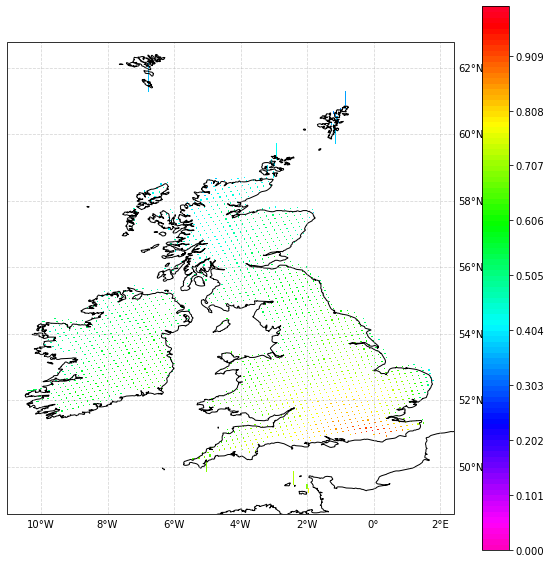

In [91]:
#Regional map
region=[-11,2,50,61] #[lon_min,lon_max,lat_min,lat_max]

projection = cartopy.crs.PlateCarree(central_longitude=0.0, globe=None)
transform=cartopy.crs.PlateCarree()

plt.figure(figsize=(10,10))
ax = plt.axes(projection=projection)

ax.coastlines()
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

bounds = np.linspace(0,1,100)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=100)
#cmap=plt.get_cmap('YlOrRd')
cmap=plt.get_cmap('gist_rainbow_r')
#fig=ax.contourf(lons,lats,da,transform=transform,norm=norm,cmap=cmap,levels=bounds)
#da.plot.pcolormesh(cmap=cmap, norm=norm)
fig = da.plot(cmap=cmap, norm=norm,transform=transform) # alternative: transform=ccrs.OSGB()